In [1]:
#import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import datetime
from sqlalchemy import create_engine
import sqlite3 as sql 

## Read Data

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
week_nums = [160618, 160625, 160702,170617,170624,170701,180616,180623,180630,190615,190622,190629]
mta = get_data(week_nums)

In [3]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2383351 entries, 0 to 205962
Data columns (total 11 columns):
 #   Column                                                                Dtype 
---  ------                                                                ----- 
 0   C/A                                                                   object
 1   UNIT                                                                  object
 2   SCP                                                                   object
 3   STATION                                                               object
 4   LINENAME                                                              object
 5   DIVISION                                                              object
 6   DATE                                                                  object
 7   TIME                                                                  object
 8   DESC                                                           

In [4]:
mta.shape

(2383351, 11)

In [5]:
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,00:00:00,REGULAR,5703420,1930887
1,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,04:00:00,REGULAR,5703465,1930891
2,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,08:00:00,REGULAR,5703487,1930933
3,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,12:00:00,REGULAR,5703589,1931038
4,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,16:00:00,REGULAR,5703880,1931107


## Remove spaces in coulmns values 

In [6]:
mta.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [7]:
# remove spaces
mta.columns = mta.columns.str.strip()
mta.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

## Check the duplicated and remove it if any  

In [8]:
#count duplicates 
sum(mta.duplicated(subset = ['C/A', 'TIME', 'DATE' , 'UNIT', 'SCP' , 'STATION']))

11

In [9]:
#drop the duplicates 
mta.drop_duplicates(subset = ['C/A', 'TIME', 'DATE' , 'UNIT', 'SCP' , 'STATION'],inplace=True)

In [10]:
mta.shape

(2383340, 11)

In [11]:
#count the null values 
mta.isnull().sum()

C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

## Add needed columns 

In [12]:
#Add datetime column
mta["DATETIME"] = pd.to_datetime(mta.DATE + " " + mta.TIME, format="%m/%d/%Y %H:%M:%S")

In [13]:
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,00:00:00,REGULAR,5703420,1930887,2016-06-11 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,04:00:00,REGULAR,5703465,1930891,2016-06-11 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,08:00:00,REGULAR,5703487,1930933,2016-06-11 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,12:00:00,REGULAR,5703589,1931038,2016-06-11 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,16:00:00,REGULAR,5703880,1931107,2016-06-11 16:00:00


In [14]:
#Add DAYNAME column
mta["NAME_OF_DAY"]= mta['DATETIME'].dt.day_name()

In [15]:
# extract the year
mta['YEAR']= mta['DATETIME'].apply(lambda x: x.year)

In [16]:
# extract the turnstile
mta["TURNSTILE"] =mta.STATION + ' ' + mta.UNIT +  ' ' + mta['C/A'] +  ' ' +  mta.SCP

In [17]:
sum(mta.duplicated(subset= ["DATETIME","TURNSTILE"]))

0

In [18]:
# to find the entries+ exits daily numbers
turn_classify = mta.groupby(['TURNSTILE'])

In [19]:
#extract the daily entries and exits
mta['ENTRIES_NUM'] = turn_classify['ENTRIES'].transform(pd.Series.diff)
mta['EXITS_NUM'] = turn_classify['EXITS'].transform(pd.Series.diff)

In [20]:
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,NAME_OF_DAY,YEAR,TURNSTILE,ENTRIES_NUM,EXITS_NUM
0,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,00:00:00,REGULAR,5703420,1930887,2016-06-11 00:00:00,Saturday,2016,59 ST R051 A002 02-00-00,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,04:00:00,REGULAR,5703465,1930891,2016-06-11 04:00:00,Saturday,2016,59 ST R051 A002 02-00-00,45.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,08:00:00,REGULAR,5703487,1930933,2016-06-11 08:00:00,Saturday,2016,59 ST R051 A002 02-00-00,22.0,42.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,12:00:00,REGULAR,5703589,1931038,2016-06-11 12:00:00,Saturday,2016,59 ST R051 A002 02-00-00,102.0,105.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,16:00:00,REGULAR,5703880,1931107,2016-06-11 16:00:00,Saturday,2016,59 ST R051 A002 02-00-00,291.0,69.0


In [21]:
# to make sure that there is no duplicated rows 
(mta
 .groupby(["TURNSTILE", "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,TURNSTILE,DATETIME,ENTRIES
0,1 AV R248 H007 00-00-00,2016-06-11 00:00:00,1
1588870,GRD CNTRL-42 ST R046 R238 00-03-04,2016-06-25 04:00:00,1
1588890,GRD CNTRL-42 ST R046 R238 00-03-04,2016-06-28 08:00:00,1
1588891,GRD CNTRL-42 ST R046 R238 00-03-04,2016-06-28 12:00:00,1
1588892,GRD CNTRL-42 ST R046 R238 00-03-04,2016-06-28 16:00:00,1


In [22]:
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,NAME_OF_DAY,YEAR,TURNSTILE,ENTRIES_NUM,EXITS_NUM
0,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,00:00:00,REGULAR,5703420,1930887,2016-06-11 00:00:00,Saturday,2016,59 ST R051 A002 02-00-00,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,04:00:00,REGULAR,5703465,1930891,2016-06-11 04:00:00,Saturday,2016,59 ST R051 A002 02-00-00,45.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,08:00:00,REGULAR,5703487,1930933,2016-06-11 08:00:00,Saturday,2016,59 ST R051 A002 02-00-00,22.0,42.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,12:00:00,REGULAR,5703589,1931038,2016-06-11 12:00:00,Saturday,2016,59 ST R051 A002 02-00-00,102.0,105.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,06/11/2016,16:00:00,REGULAR,5703880,1931107,2016-06-11 16:00:00,Saturday,2016,59 ST R051 A002 02-00-00,291.0,69.0


In [23]:
# define a daily dataframe
turnsile_df = (mta.groupby(["DIVISION","C/A", "UNIT", "SCP", "STATION", "DATE", "YEAR"],as_index=False)
                        ['ENTRIES', 'EXITS'].first())

<ipython-input-23-8e9a1c2975ba>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnsile_df = (mta.groupby(["DIVISION","C/A", "UNIT", "SCP", "STATION", "DATE", "YEAR"],as_index=False)


In [24]:
import datetime
turnsile_df["DATETIME"] = pd.to_datetime(turnsile_df['DATE'])

In [25]:
#sort the data based on date
turnsile_df= turnsile_df.sort_values('DATETIME', ascending= True)

In [26]:
#add previous entries, exits, and date
turnsile_df[['PREV_DATE',"PREV_ENTRIES", 'PREV_EXITS']]= (turnsile_df.groupby(["C/A", "UNIT", "SCP", "STATION", "YEAR"])["DATETIME","ENTRIES", 'EXITS'].shift())

<ipython-input-26-980d1b6dda52>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnsile_df[['PREV_DATE',"PREV_ENTRIES", 'PREV_EXITS']]= (turnsile_df.groupby(["C/A", "UNIT", "SCP", "STATION", "YEAR"])["DATETIME","ENTRIES", 'EXITS'].shift())


In [27]:
# to drop the first day of each year
turnsile_df.dropna(subset=["PREV_ENTRIES"], axis=0, inplace=True)

In [28]:
# daily entries
def get_daily_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = abs(counter)
    if counter > max_counter:
        return 0
    return counter

In [29]:
# daily exits
def get_daily_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = abs(counter)
    if counter > max_counter:
        return 0
    return counter

In [30]:
# extract the daily entries to known the traffic 
turnsile_df["DAILY_ENTRIES"] = turnsile_df.apply(get_daily_entries, axis=1, max_counter=100000)

In [31]:
# extract the daily exits to known the traffic 
turnsile_df["DAILY_EXITS"] = turnsile_df.apply(get_daily_exits, axis=1, max_counter=100000)

In [32]:
#add the traffic column
turnsile_df["TRAFFIC"]= turnsile_df['DAILY_ENTRIES'] + turnsile_df['DAILY_EXITS']

In [33]:
turnsile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376488 entries, 269467 to 387869
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   DIVISION       376488 non-null  object        
 1   C/A            376488 non-null  object        
 2   UNIT           376488 non-null  object        
 3   SCP            376488 non-null  object        
 4   STATION        376488 non-null  object        
 5   DATE           376488 non-null  object        
 6   YEAR           376488 non-null  int64         
 7   ENTRIES        376488 non-null  int64         
 8   EXITS          376488 non-null  int64         
 9   DATETIME       376488 non-null  datetime64[ns]
 10  PREV_DATE      376488 non-null  datetime64[ns]
 11  PREV_ENTRIES   376488 non-null  float64       
 12  PREV_EXITS     376488 non-null  float64       
 13  DAILY_ENTRIES  376488 non-null  float64       
 14  DAILY_EXITS    376488 non-null  float64       


## merge with external data

In [34]:
# read. the. external data
stations_borough = pd.read_csv("stations.csv")

In [35]:
#check duplicates
sum(stations_borough.duplicated())

0

In [36]:
#convert the columns values to uppercase
stations_borough.columns = stations_borough.columns.str.upper()

In [37]:
stations_borough.columns

Index(['STATION', 'LINE_NAMES', 'DIVISION', 'BOROUGH', 'SUBREGION'], dtype='object')

In [38]:
# drop the unneeded columns 
stations_borough.drop(['LINE_NAMES','DIVISION','SUBREGION'], inplace = True, axis =1)

In [39]:
stations_borough.columns

Index(['STATION', 'BOROUGH'], dtype='object')

In [40]:
# merge the dataframes 
turnsile_df = (pd.merge(turnsile_df, stations_borough, on='STATION'))
turnsile_df.columns

Index(['DIVISION', 'C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'YEAR', 'ENTRIES',
       'EXITS', 'DATETIME', 'PREV_DATE', 'PREV_ENTRIES', 'PREV_EXITS',
       'DAILY_ENTRIES', 'DAILY_EXITS', 'TRAFFIC', 'BOROUGH'],
      dtype='object')

## SQL 

**Add the dataset to the SQLite**

In [41]:
#connect with sql
conn = sql.connect('turnsile_df.db')

In [42]:
turnsile_df.to_sql('turnsile_df', conn)

**Read the data from SQLite**

In [43]:
connection= sql.connect('turnsile_df.db')

In [44]:
daily_turnsile= pd.read_sql('SELECT * FROM turnsile_df', connection)

## Figures and Relations 

In [45]:
# extract the data with only year 2016
mask = ((daily_turnsile['YEAR'] == 2016))

In [46]:
mask2 = ((daily_turnsile['YEAR'] == 2017))

In [47]:
mask3 = ((daily_turnsile['YEAR'] == 2018))

In [48]:
mask4 = ((daily_turnsile['YEAR'] == 2019))

In [49]:
#calculate the top traffic of year 2016
top_2016 =daily_turnsile[mask].groupby(['STATION']).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = False).reset_index().head(5)
top_2016

,STATION,TRAFFIC
0,23 ST,22046136.0
1,86 ST,17010495.0
2,34 ST-HERALD SQ,16941084.0
3,34 ST-PENN STA,16751658.0
4,59 ST,15385842.0


In [50]:
top_2017 =daily_turnsile[mask2].groupby(['STATION']).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = False).reset_index().head(5)
top_2017

,STATION,TRAFFIC
0,23 ST,21029664.0
1,34 ST-HERALD SQ,17143944.0
2,34 ST-PENN STA,16276758.0
3,86 ST,14920815.0
4,FULTON ST,14799740.0


In [51]:
top_2018 =daily_turnsile[mask3].groupby(['STATION']).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = False).reset_index().head(5)
top_2018

,STATION,TRAFFIC
0,23 ST,20460204.0
1,34 ST-HERALD SQ,16949836.0
2,34 ST-PENN STA,16139094.0
3,FULTON ST,15378475.0
4,TIMES SQ-42 ST,14410488.0


In [52]:
top_2019=daily_turnsile[mask4].groupby(['STATION']).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = False).reset_index().head(5)
top_2019

,STATION,TRAFFIC
0,23 ST,20797416.0
1,34 ST-HERALD SQ,17170284.0
2,34 ST-PENN STA,17105661.0
3,FULTON ST,15601160.0
4,TIMES SQ-42 ST,14886120.0


/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

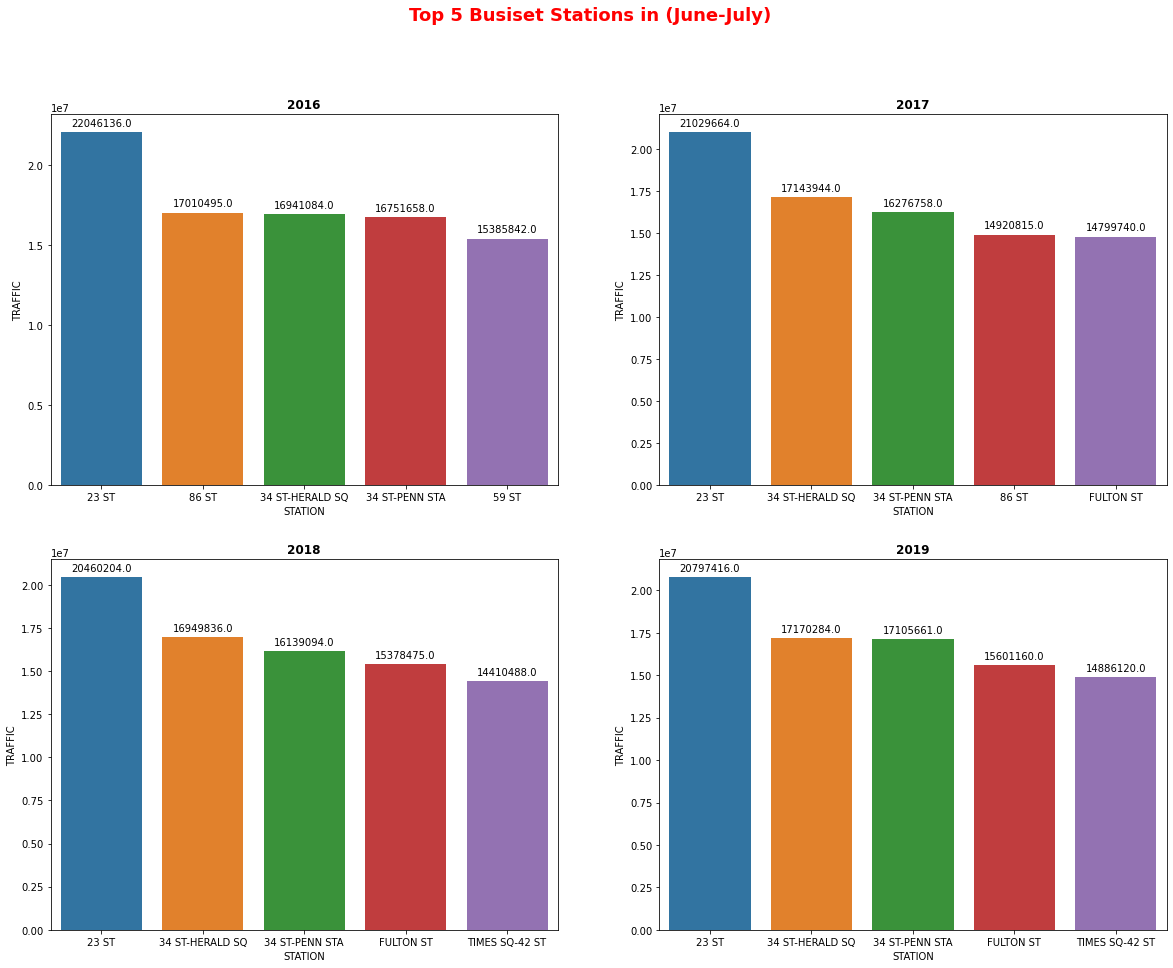

In [53]:
# plot the top 5 buiesist stations in all years by using subplot 
plt.figure(figsize=[20,15])
plt.style.use('default')


plt.suptitle('Top 5 Busiset Stations in (June-July)',fontsize = 18, weight="bold",c="red")

plt.subplot(2,2,1) 
ax = sns.barplot(top_2016['STATION'],top_2016['TRAFFIC'], data=top_2016)
plt.title('2016', weight="bold");  
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')


plt.subplot(2,2,2) 
ax = sns.barplot(top_2017['STATION'],top_2017['TRAFFIC'], data=top_2017)
plt.title('2017', weight="bold");
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')


plt.subplot(2,2,3) 
ax = sns.barplot(top_2018['STATION'],top_2018['TRAFFIC'], data=top_2018)
plt.title('2018', weight="bold");
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.subplot(2,2,4) 
ax = sns.barplot(top_2019['STATION'],top_2019['TRAFFIC'], data=top_2019)
plt.title('2019', weight="bold");
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.savefig('Top stationns.png')

In [54]:
#calculate the least traffic of year 2016
least_2016 =daily_turnsile[mask].groupby(['STATION']).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = True).reset_index().head(5)
least_2016

,STATION,TRAFFIC
0,ORCHARD BEACH,329.0
1,BROAD CHANNEL,7891.0
2,TOMPKINSVILLE,13743.0
3,BEACH 105 ST,16129.0
4,BEACH 44 ST,26196.0


In [55]:
least_2017 =daily_turnsile[mask2].groupby(['STATION']).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = True).reset_index().head(5)
least_2017

,STATION,TRAFFIC
0,ORCHARD BEACH,491.0
1,BROAD CHANNEL,7269.0
2,TOMPKINSVILLE,14345.0
3,121 ST,16430.0
4,BEACH 105 ST,16736.0


In [56]:
least_2018 =daily_turnsile[mask3].groupby(['STATION']).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = True).reset_index().head(5)
least_2018

,STATION,TRAFFIC
0,ORCHARD BEACH,685.0
1,BROAD CHANNEL,6943.0
2,TOMPKINSVILLE,14339.0
3,BEACH 105 ST,14406.0
4,AVENUE I,16462.0


In [57]:
least_2019 =daily_turnsile[mask4].groupby(['STATION']).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = True).reset_index().head(5)
least_2019

,STATION,TRAFFIC
0,ORCHARD BEACH,2368.0
1,BROAD CHANNEL,7285.0
2,TOMPKINSVILLE,12464.0
3,BEACH 105 ST,13621.0
4,BEACH 98 ST,23729.0


/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/amjad/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

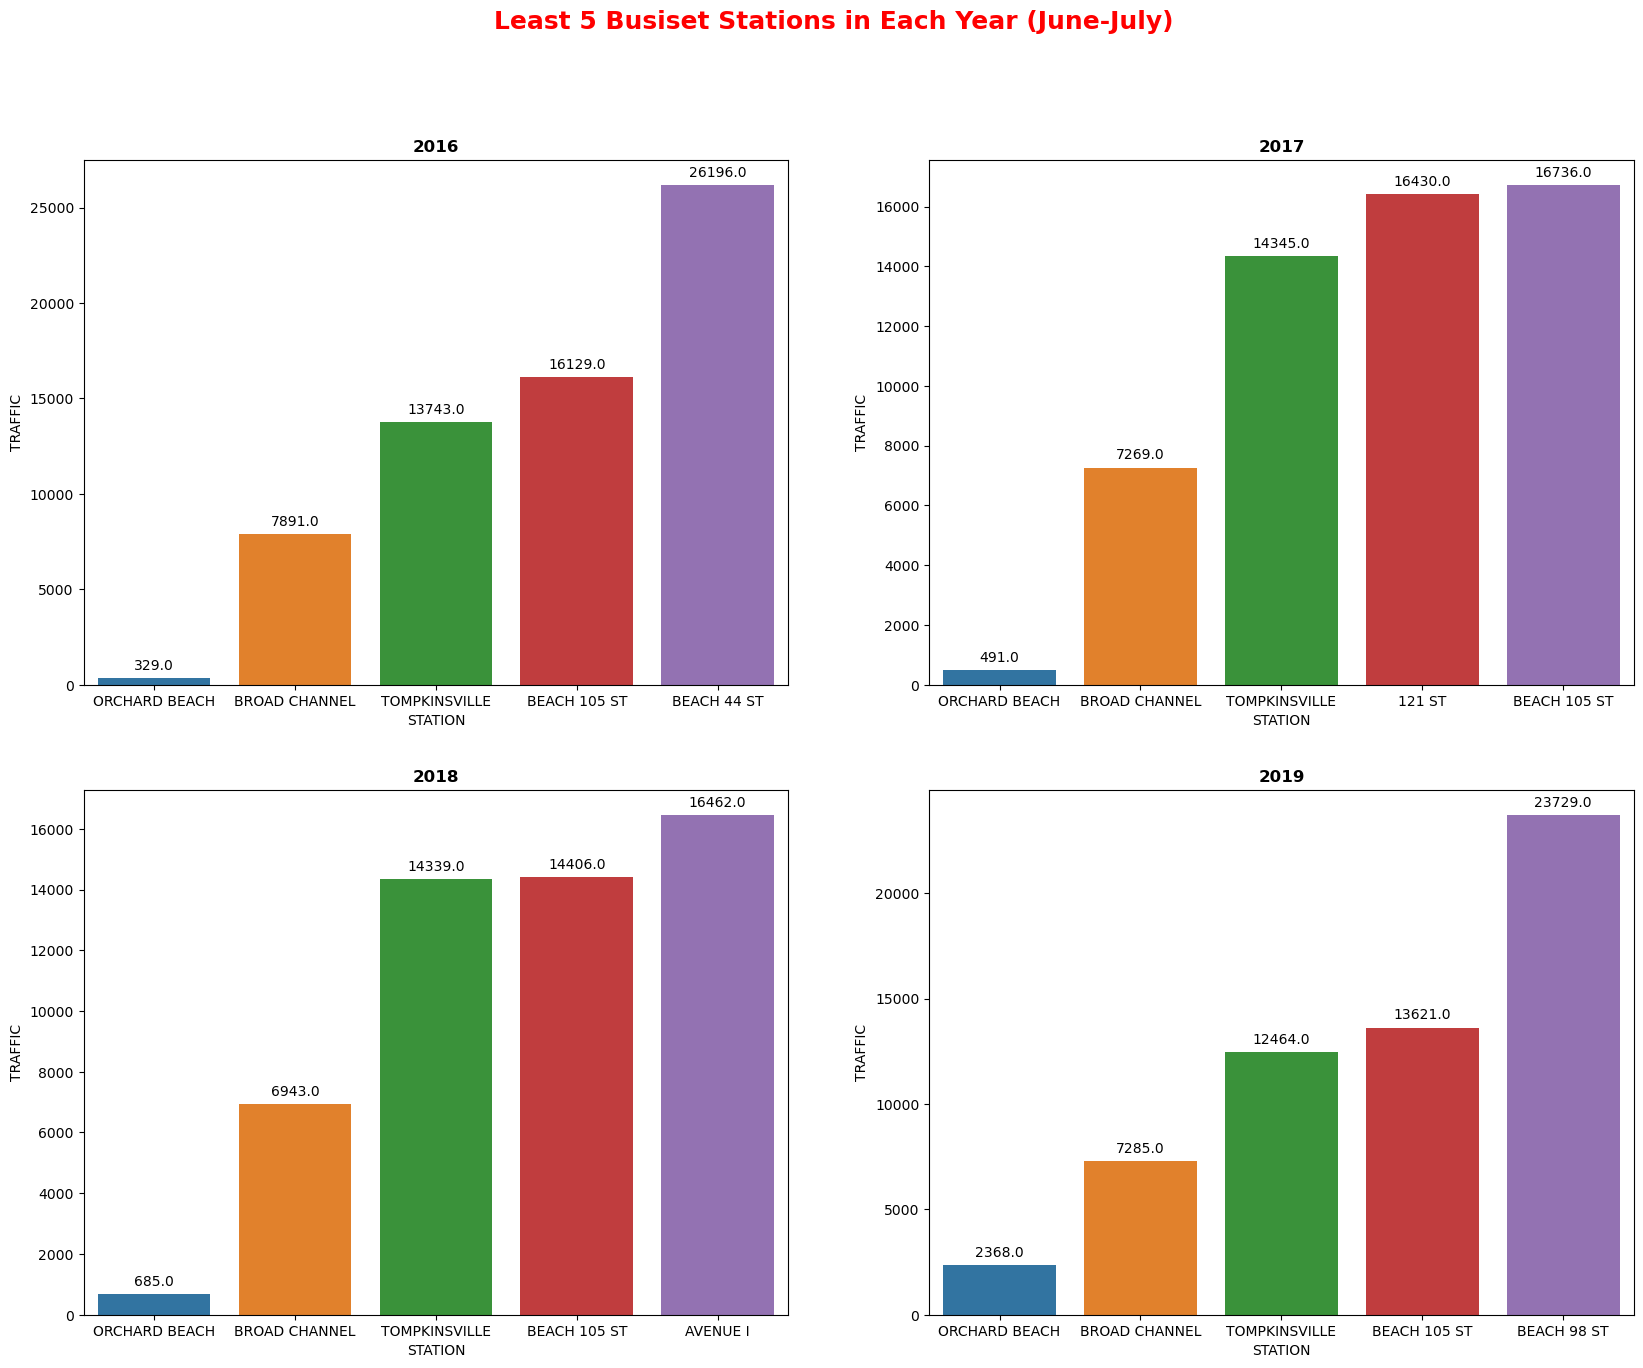

In [58]:
# plot the least 5 buiesist stations in all years by using subplot 
plt.figure(figsize=[20,15])
plt.style.use('default')


plt.suptitle('Least 5 Busiset Stations in Each Year (June-July)',fontsize = 18, weight="bold",c="red")

plt.subplot(2,2,1) 
ax = sns.barplot(least_2016['STATION'],least_2016['TRAFFIC'], data=least_2016)
plt.title('2016', weight="bold");  
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.subplot(2,2,2) 
ax = sns.barplot(least_2017['STATION'],least_2017['TRAFFIC'], data=least_2017)
plt.title('2017', weight="bold");
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.subplot(2,2,3) 
ax = sns.barplot(least_2018['STATION'],least_2018['TRAFFIC'], data=least_2018)
plt.title('2018', weight="bold");
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.subplot(2,2,4) 
ax = sns.barplot(least_2019['STATION'],least_2019['TRAFFIC'], data=least_2019)
plt.title('2019', weight="bold");
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig('Least stationns.png')

In [59]:
# find each of the top traffic stations belong to which borough
top_stations_boroughs=daily_turnsile.groupby(['STATION',"BOROUGH"]).agg({'TRAFFIC': sum}).sort_values(by = 'TRAFFIC', ascending = False).reset_index().head()
top_stations_boroughs

,STATION,BOROUGH,TRAFFIC
0,23 ST,Manhattan,84333420.0
1,34 ST-HERALD SQ,Manhattan,68205148.0
2,34 ST-PENN STA,Manhattan,66273171.0
3,TIMES SQ-42 ST,Manhattan,57816748.0
4,14 ST-UNION SQ,Manhattan,56907788.0


In [60]:
# must convert it due to the onfusion in type after the connection with SQL
daily_turnsile["DATETIME"] = pd.to_datetime(daily_turnsile.DATETIME)

In [61]:
daily_turnsile["NAME_OF_DAY"]= daily_turnsile['DATETIME'].dt.day_name()

In [62]:
#calculate the daily traffic for all stations 
daily_traffic = daily_turnsile.groupby(['NAME_OF_DAY']).agg({'TRAFFIC': sum}).sort_values("TRAFFIC", ascending=False).reset_index()

In [63]:
daily_traffic

,NAME_OF_DAY,TRAFFIC
0,Thursday,276698253.0
1,Wednesday,273622549.0
2,Friday,271699223.0
3,Tuesday,259395956.0
4,Saturday,178608640.0
5,Sunday,156951018.0
6,Monday,129336766.0


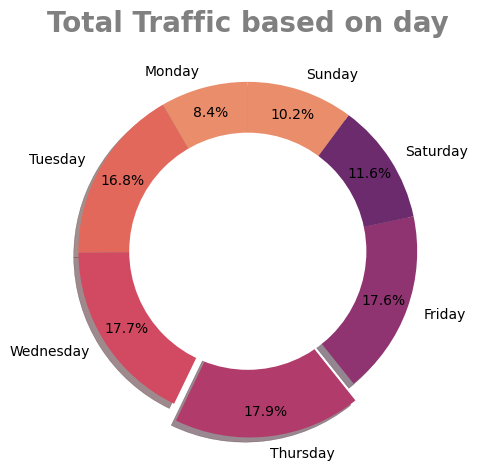

In [64]:
# plot the daily traffic for all stations in all years
plt.style.use('seaborn-notebook')
fig1, ax1 = plt.subplots()
day = 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
traffic = [129336766, 259395956, 273622549, 276698253 ,271699223,178608640,156951018]
explode = (0, 0, 0, 0.1 ,0,0,0)  
colors = sns.color_palette("flare")
ax1.pie(traffic,explode=explode,labels=day,  pctdistance=0.85, autopct='%1.1f%%', startangle=90,shadow=True,colors=colors)
plt.title("Total Traffic based on day", weight="bold", c="grey", fontsize=20)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)   


plt.savefig('Total traffic.png')
plt.show()


In [65]:
#calculate the mean of the traffic for the top trafficed statiions in each year for each day
top5_hm_2016 = daily_turnsile[mask].groupby(["STATION","NAME_OF_DAY"]).TRAFFIC.mean().reset_index().sort_values('TRAFFIC', ascending= False)

top5_hm_2016 = top5_hm_2016.pivot("STATION","NAME_OF_DAY","TRAFFIC").head()


top5_hm_2017 = daily_turnsile[mask2].groupby(["STATION","NAME_OF_DAY"]).TRAFFIC.mean().reset_index().sort_values('TRAFFIC', ascending= False)

top5_hm_2017 = top5_hm_2017.pivot("STATION","NAME_OF_DAY","TRAFFIC").head()


top5_hm_2018 = daily_turnsile[mask3].groupby(["STATION","NAME_OF_DAY"]).TRAFFIC.mean().reset_index().sort_values('TRAFFIC', ascending= False)

top5_hm_2018 = top5_hm_2018.pivot("STATION","NAME_OF_DAY","TRAFFIC").head()


top5_hm_2019 = daily_turnsile[mask4].groupby(["STATION","NAME_OF_DAY"]).TRAFFIC.mean().reset_index().sort_values('TRAFFIC', ascending= False)

top5_hm_2019 = top5_hm_2019.pivot("STATION","NAME_OF_DAY","TRAFFIC").head()

top5_hm_2016

NAME_OF_DAY,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
STATION,,,,,,,
1 AV,4762.533333,3249.200000,5111.700000,3965.100000,4771.566667,4595.366667,4782.133333
103 ST,3708.533333,2041.288889,3798.400000,2544.688889,3771.622222,3620.888889,3749.911111
103 ST-CORONA,3813.444444,2459.851852,3964.777778,3064.481481,3896.370370,3693.518519,3804.740741
104 ST,744.518519,266.407407,784.777778,340.925926,757.666667,777.703704,788.444444
110 ST,3657.333333,2104.055556,3868.583333,2902.666667,3736.722222,3624.611111,3661.500000


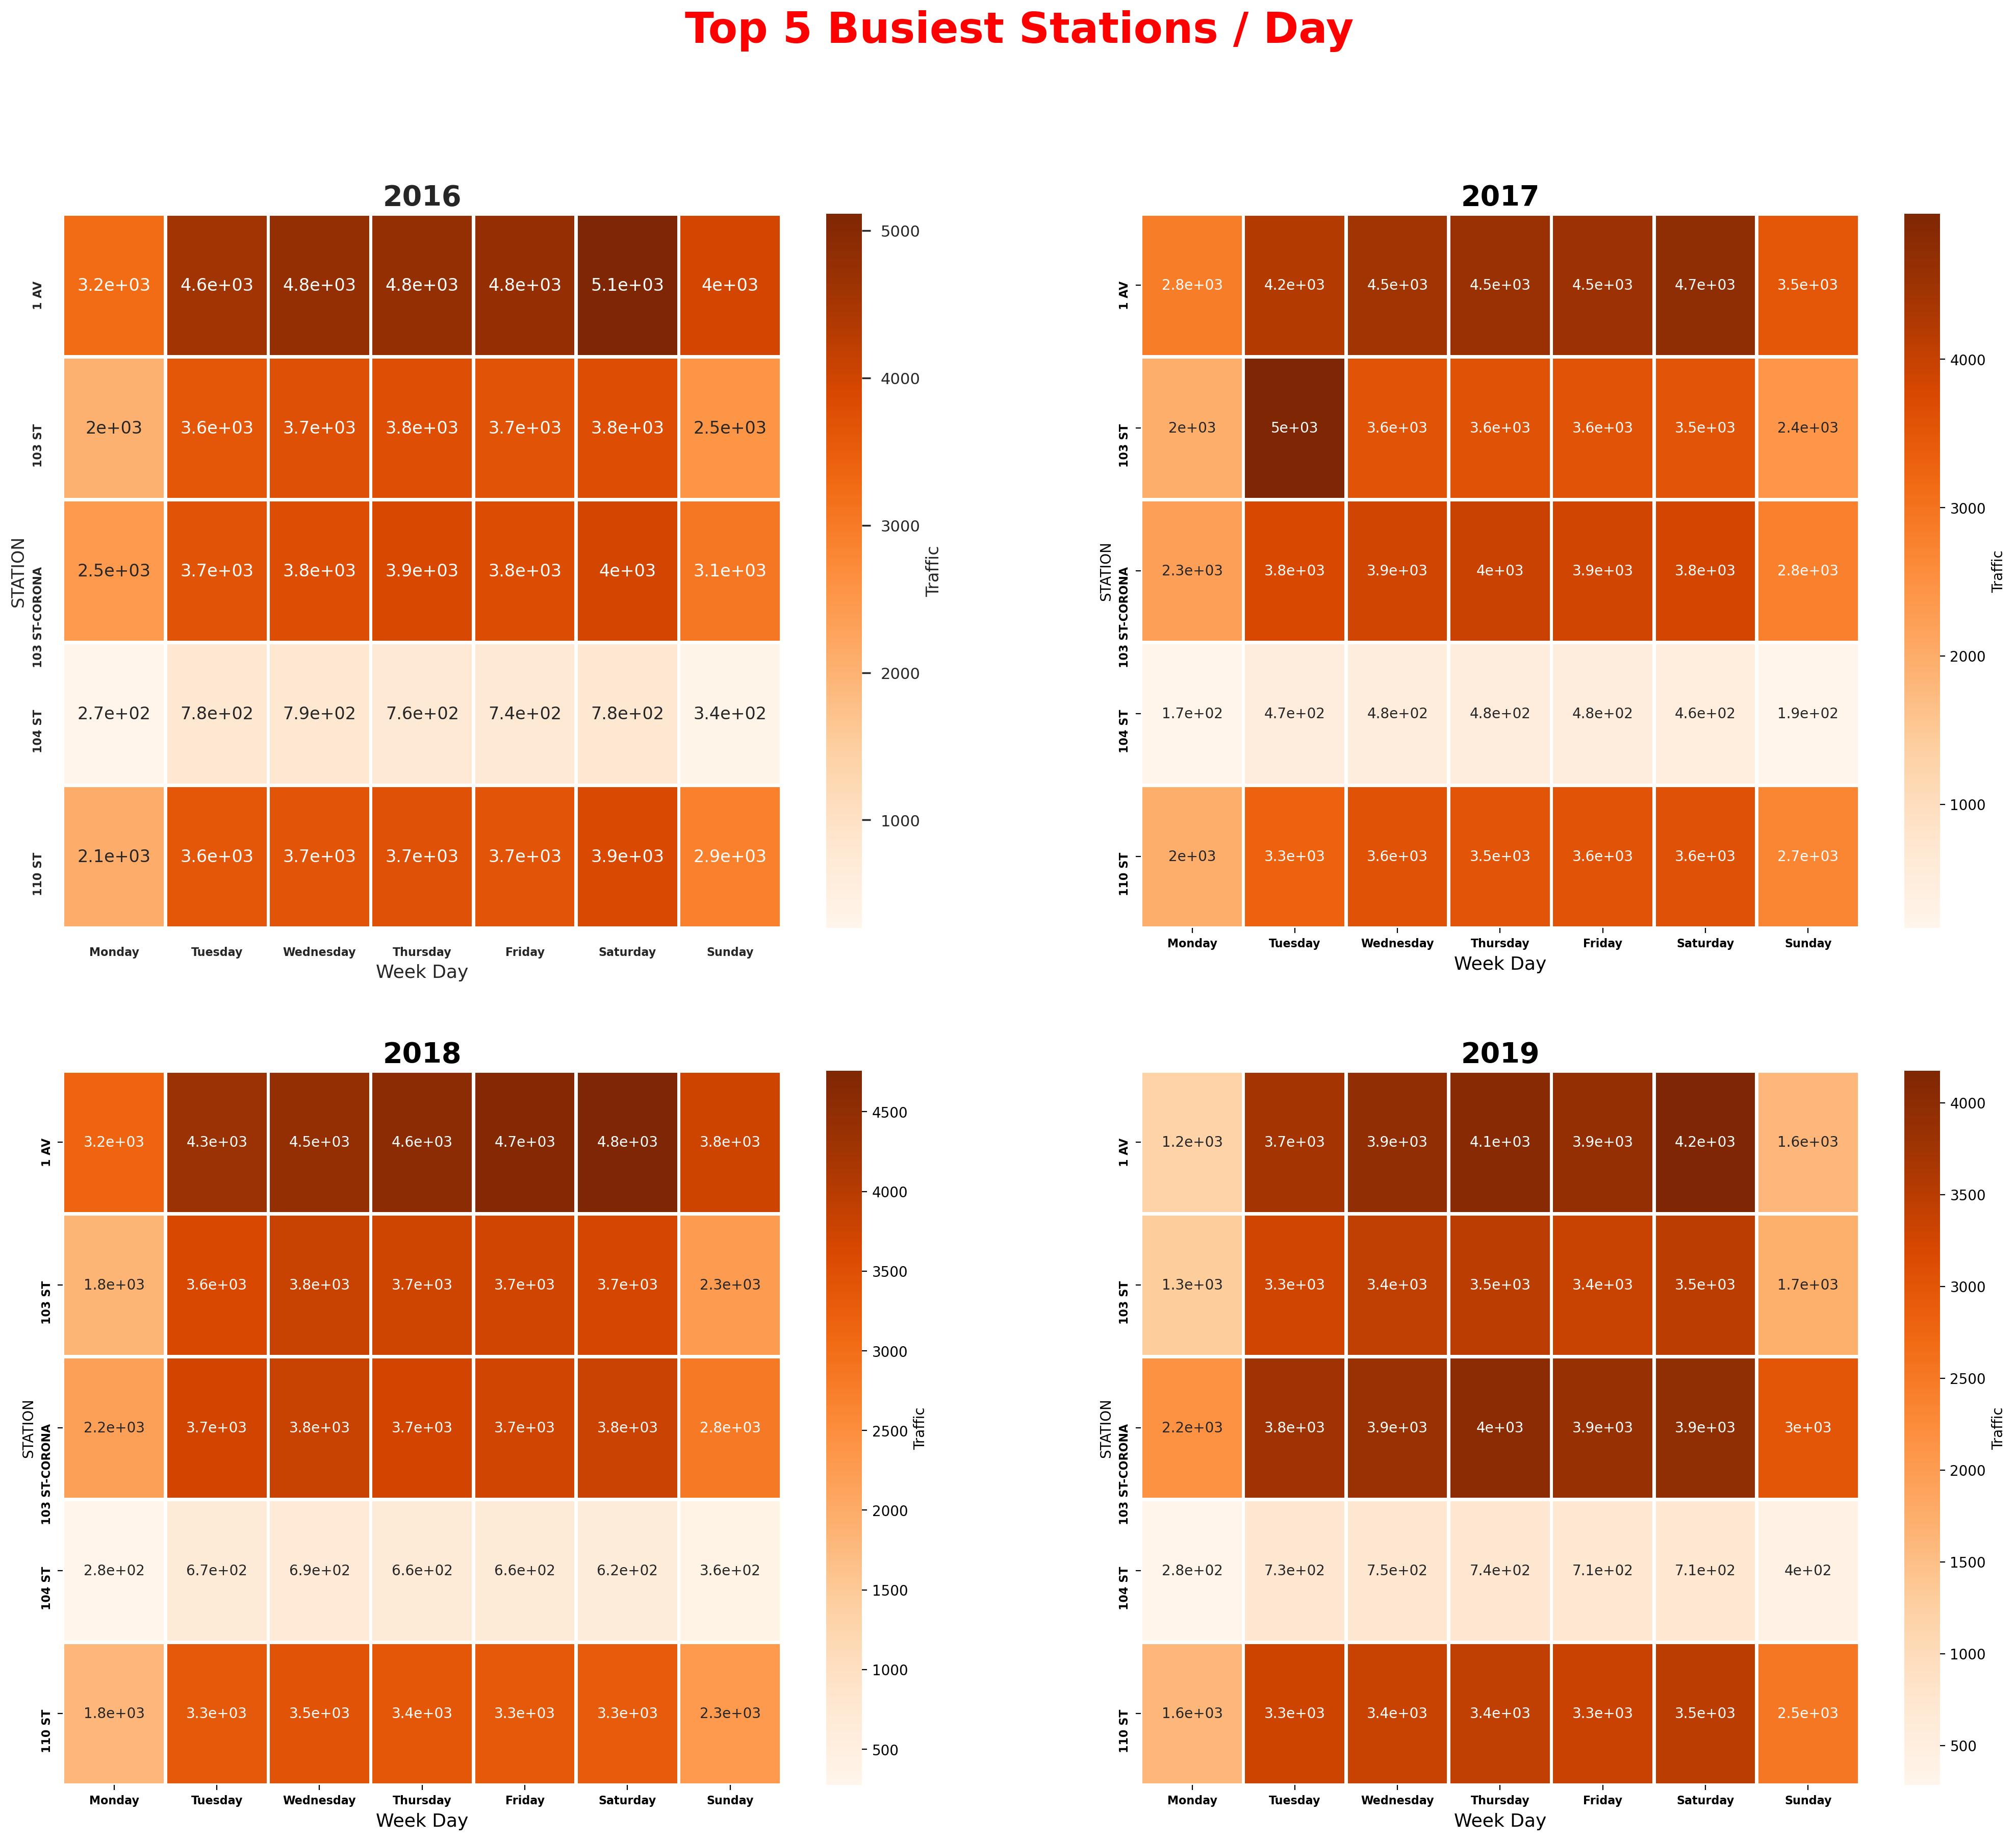

In [67]:
#plot the traffic mean for the top trafficed statiions in each year for each day
top_sorted_2016 = top5_hm_2016[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
top_sorted_2017 = top5_hm_2017[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
top_sorted_2018 = top5_hm_2018[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
top_sorted_2019 = top5_hm_2019[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]


plt.figure(figsize=(25,20),dpi=200),
plt.suptitle("Top 5 Busiest Stations / Day",weight="bold",c="red", fontsize=30)
sns.set(font_scale=1)
plt.subplot(2,2,1)
sns.heatmap(top_sorted_2016,annot=True, linewidths=2, cmap="Oranges",cbar_kws={'label': 'Traffic'})
plt.style.use('default')
plt.xlabel('Week Day', fontsize= 13)
plt.yticks(weight="bold", size=8)
plt.xticks(weight="bold",size=8)
plt.title('2016', weight="bold", fontsize= 20);


plt.subplot(2,2,2)
sns.heatmap(top_sorted_2017,annot=True, linewidths=2, cmap="Oranges",cbar_kws={'label': 'Traffic'})
plt.style.use('default')
plt.xlabel('Week Day', fontsize= 13)
plt.yticks(weight="bold", size=8)
plt.xticks(weight="bold",size=8)
plt.title('2017', weight="bold", fontsize= 20);


plt.subplot(2,2,3)
sns.heatmap(top_sorted_2018,annot=True, linewidths=2, cmap="Oranges",cbar_kws={'label': 'Traffic'})
plt.style.use('default')
plt.xlabel('Week Day', fontsize= 13)
plt.yticks(weight="bold", size=8)
plt.xticks(weight="bold",size=8)
plt.title('2018', weight="bold", fontsize= 20);

plt.subplot(2,2,4)
sns.heatmap(top_sorted_2019,annot=True, linewidths=2, cmap="Oranges",cbar_kws={'label': 'Traffic'});
plt.style.use('default')
plt.xlabel('Week Day', fontsize= 13)
plt.yticks(weight="bold", size=8);
plt.xticks(weight="bold",size=8);
plt.title('2019', weight="bold", fontsize= 20);



plt.savefig('heatmap.png')